# Question: Can we predict a country's math, science, and reading test scores based on the average years of schooling, pupil-teacher ratios, government expenditure per pupil, and other features?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
df_quality1 = pd.read_csv('https://raw.githubusercontent.com/urbanobruno/data-science-project-stanford/master/prepared_data/quality1.csv')
df_quality2 = pd.read_csv('https://raw.githubusercontent.com/urbanobruno/data-science-project-stanford/master/prepared_data/quality2.csv')

In [3]:
df_quality2.head()

,SHCODE,COUNTRY,M_64_13,M_64_FS,M_8283_13,M_8283_FS,M_88_13,M_9091_10,M_9091_14,M_9398_13,...,S_84_10,S_84_13,S_84_FS,S_88_13,S_9091_9,S_9091_13,S_9398_13,R_7072_13,R_9091_9,R_9091_13
0,4,Botswana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0
1,25,Malawi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN
2,30,Mozambique,NaN,NaN,NaN,NaN,NaN,NaN,28.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,Nigeria,NaN,NaN,33.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1
4,38,South Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.8,...,NaN,NaN,NaN,NaN,NaN,NaN,31.7,NaN,NaN,NaN


In [4]:
df_quality1.head()

,SHCODE,WBCTRY,COUNTRY,TEAPRI60,TEAPRI65,TEAPRI70,TEAPRI75,TEAPRI80,TEAPRI85,TEAPRI90,...,SHSALP75,SHSALP80,SHSALP85,SHSALP90,DROP70,DROP75,DROP80,DROP85,DROP90,CONTINENT
0,1,DZA,Algeria,38.299999,44.299999,40.000000,40.900002,35.200001,27.799999,27.700001,...,599.0,296.0,NaN,350.0,31.3,28.8,23.5,9.8,10.0,Africa
1,2,AGO,Angola,35.400002,45.200001,44.400002,NaN,31.500000,31.299999,31.900000,...,NaN,NaN,NaN,NaN,66.0,66.0,66.0,66.0,66.0,Africa
2,3,BEN,Benin,40.500000,41.700001,44.299999,48.299999,47.500000,33.000000,34.700001,...,411.0,769.0,NaN,NaN,64.0,64.0,64.0,64.0,60.0,Africa
3,4,BWA,Botswana,31.500000,40.000000,36.500000,33.099998,32.299999,32.000000,31.700001,...,262.0,252.0,287.0,NaN,50.4,18.2,26.7,10.7,20.0,Africa
4,5,HVO,Burkina Faso,NaN,NaN,NaN,47.099998,54.500000,56.500000,56.700001,...,1528.0,1184.0,884.0,NaN,51.0,38.3,25.1,26.2,29.0,Africa


In [5]:
# KNN finds best parameters:

def findsBestParametersKNN(X, y, rangeK=range(1, 15)):
    grid_cv = GridSearchCV(
        KNeighborsRegressor(),
        {
            'n_neighbors': rangeK,
            'metric': ['euclidean', 'manhattan']
        },
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
        )

    grid_cv.fit(X, y)

    return grid_cv.best_estimator_

In [6]:
def calculatesRMSEusingCV(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    return cv_rmse

In [7]:
school_time_features = ['SCHDAY', 'SCHTIME']
features_1990 = ['TEAPRI90', 'TEASEC90', 'GEEPRI90', 'GEESEC90', 'SHPUPS90', 'SALARP90', 'SHSALP90']
features_1985 = ['TEAPRI85', 'TEASEC85', 'GEEPRI85', 'GEESEC85', 'SHPUPS85', 'SALARP85', 'SHSALP85']
features_1985_1990 = features_1985 + features_1990 + school_time_features

features_1985 += school_time_features
features_1990 += school_time_features

# Predicting Math Score (M_9398_13)

We are focusing on the math scores from 1993-1998 (M_9398_13)

We will use the features from the year 1990 to predict these tests, since they are the ones closest to when the test ocurred. We will also check if using the features from 1985 helps the prediction.

In [8]:
df_math_9398_13 = df_quality2[['SHCODE', 'COUNTRY', 'M_9398_13']].dropna(subset=['M_9398_13'])

In [9]:
# Since we are predicting a score from the year 1993-1998, it makes sense to use the features of the year 1990
df_quality_selected = df_quality1[['SHCODE', 'COUNTRY'] + features_1990]
df_math_merged = pd.merge(df_math_9398_13, df_quality_selected, on=['SHCODE', 'COUNTRY'], how='inner')

# Since we have don't many values, I'm filling the NANs with the mean values of each column
df_math_merged[features_1990] = df_math_merged[features_1990].fillna(df_math_merged[features_1990].mean())

In [10]:
rmse_math_knn = {}
rmse_math_linear = {}

In [11]:
df_math_merged

,SHCODE,COUNTRY,M_9398_13,TEAPRI90,TEASEC90,GEEPRI90,GEESEC90,SHPUPS90,SALARP90,SHSALP90,SCHDAY,SCHTIME
0,50,Canada,49.4,15.300000,14.000000,3861.000000,4251.000000,24.700001,39970.000000,233.00,195.0,975.000000
1,66,United States,47.6,18.500000,14.300000,2721.000000,4181.000000,23.100000,32506.000000,180.00,179.0,1148.000000
2,71,Colombia,36.9,29.900000,19.900000,210.000000,329.000000,10.000000,25823.754167,202.15,195.0,1200.000000
3,84,Hong Kong,56.4,27.000000,23.000000,1114.000000,2386.333333,20.695000,32678.800000,202.15,208.0,999.764706
4,90,Japan,57.1,20.700001,16.700001,2333.000000,2456.000000,17.200001,39097.000000,273.00,215.0,999.764706
5,100,Singapore,60.1,25.799999,20.799999,1052.819946,2386.333333,20.695000,31584.600000,202.15,208.0,999.764706
6,104,Thailand,49.5,17.799999,17.900000,529.000000,550.000000,15.400000,7091.000000,199.00,200.0,1200.000000
7,107,Austria,50.9,10.800000,8.400000,2332.000000,3811.000000,30.000000,18675.000000,147.00,200.0,960.000000
8,108,Belgium,53.3,9.900000,7.200000,2109.000000,3630.000000,27.500000,23048.000000,174.00,182.0,999.764706
9,109,Cyprus,44.6,20.500000,11.900000,1080.000000,2242.000000,26.799999,19247.000000,230.00,210.0,840.000000


To identify which features might be good indicators of the math scores, we'll calculate the correlation of each feature with the target variable (M_9398_13).
Features with higher absolute correlation values are likely to be more predictive.

In [12]:
dic = dict()

for feature in features_1990:
    dic[feature] = df_math_merged[feature].corr(df_math_merged['M_9398_13'])

corrs = pd.Series(dic, name='Correlation')
corrs.sort_values()


,Correlation
SCHTIME,-0.086792
SHSALP90,0.017978
GEEPRI90,0.035570
TEAPRI90,0.060390
TEASEC90,0.087660
SCHDAY,0.275443
SALARP90,0.278144
SHPUPS90,0.343152
GEESEC90,0.380527




# Math: Model using all features

Now, we'll create models using all the features from 1990 to predict the math scores.

We'll use both a K-Nearest Neighbors (KNN) model and a Linear Regression model to compare their performance.

In [13]:
scaler = StandardScaler()

X = scaler.fit_transform(df_math_merged[features_1990])
y = df_math_merged['M_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='manhattan', n_neighbors=11)

In [14]:
# Defining models, KNN using best params
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=6)

In [15]:
rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_math_knn['All Features'] = rmse_knn
rmse_math_linear['All Features'] = rmse_linear

rmse_knn, rmse_linear

(5.112861777474093, 9.860944527402784)

# Math: Model using features with stronger correlation

After analyzing the correlations, we'll now use only the top three features with the highest correlation to see if they can provide a better or comparable predictive performance.


In [16]:
features_highest_corr = ['SALARP90', 'SHPUPS90', 'GEESEC90']

scaler = StandardScaler()
X = scaler.fit_transform(df_math_merged[features_highest_corr])
y = df_math_merged['M_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=12)

In [17]:

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=10, metric='manhattan')

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_math_knn['Top 3 Features'] = rmse_knn
rmse_math_linear['Top 3 Features'] = rmse_linear

rmse_knn, rmse_linear

(4.681719484690782, 4.581451843695238)

# Math: Model using features from 1985 and 1990

We now extend the analysis to include features from both 1985 and 1990.

This could provide insight into whether trends over time are better predictors than a single year's data.

We are recalculating the correlations evaluate whether features from 1985-1990 improve prediction (Initial test)

In [18]:
df_quality_selected = df_quality1[['SHCODE', 'COUNTRY'] + features_1985_1990]
df_math_merged_1985_1990 = pd.merge(df_math_9398_13, df_quality_selected, on=['SHCODE', 'COUNTRY'], how='inner')

# Since we have don't many values, I'm filling the NANs with the mean values of each column
df_math_merged_1985_1990[features_1985_1990] = df_math_merged_1985_1990[features_1985_1990].fillna(df_math_merged_1985_1990[features_1985_1990].mean())

dic = dict()

for feature in features_1985_1990:
    dic[feature] = df_math_merged_1985_1990[feature].corr(df_math_merged_1985_1990['M_9398_13'])

corrs = pd.Series(dic, name='Correlation')
corrs.sort_values()


,Correlation
SCHTIME,-0.086792
SHSALP90,0.017978
SHSALP85,0.032823
TEASEC85,0.035527
GEEPRI90,0.035570
GEEPRI85,0.047953
TEAPRI90,0.060390
TEAPRI85,0.063409
TEASEC90,0.087660
SHPUPS85,0.225700


Doesn't seem like any feature from 1985 has a strong correlation with the math test scores from 1993-98

In [19]:
scaler = StandardScaler()

X = scaler.fit_transform(df_math_merged_1985_1990[features_1985_1990])
y = df_math_merged_1985_1990['M_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=10)

In [20]:
# Defining models, KNN using best params
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=6)

In [21]:
rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_math_knn['Features 1985 + 1990'] = rmse_knn
rmse_math_linear['Features 1985 + 1990'] = rmse_linear

rmse_knn, rmse_linear

(5.015430080151543, 15.571568923448805)

We can see here that the linear model performs much worse using all the features from 1985 and 1990

However we also see that KNN performs well with a RMSE of 5.01



# Math: model using one feature

In [22]:
feature_with_highest_corr = ['GEESEC90']

scaler = StandardScaler()
X = scaler.fit_transform(df_math_merged[feature_with_highest_corr])
y = df_math_merged['M_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=12)

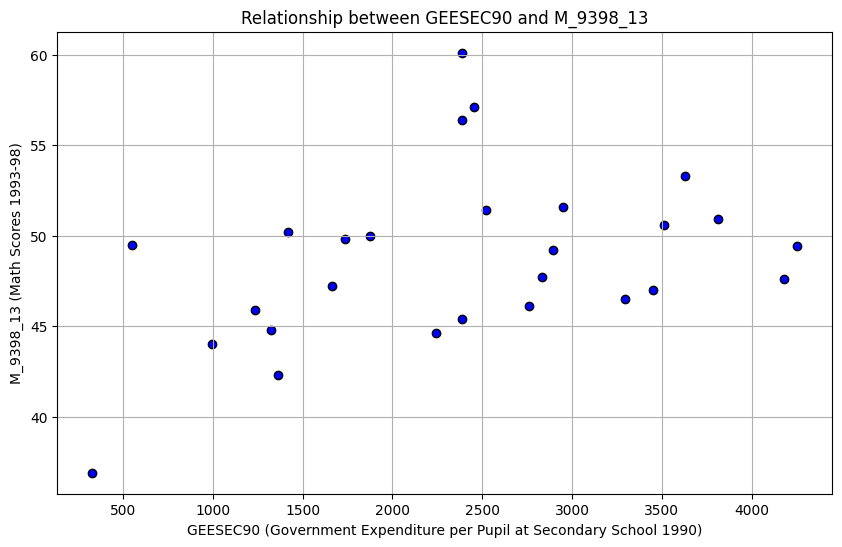

In [23]:

plt.figure(figsize=(10, 6))
plt.scatter(df_math_merged['GEESEC90'], y, color='blue', edgecolor='k')
plt.title('Relationship between GEESEC90 and M_9398_13')
plt.xlabel('GEESEC90 (Government Expenditure per Pupil at Secondary School 1990)')
plt.ylabel('M_9398_13 (Math Scores 1993-98)')
plt.grid(True)
plt.show()

In [24]:

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=11)

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_math_knn['One Feature'] = rmse_knn
rmse_math_linear['One Feature'] = rmse_linear

rmse_knn, rmse_linear

(4.747508727580952, 4.374146209498089)

# Math conclusion:

The KNN model using all features from both 1985 and 1990 achieved the best performance with an RMSE of 5.01:

- The inclusion of features from both 1985 and 1990 seems to have provided a better context for predicting the math scores from 1993-1998. This indicates that historical educational inputs and economic factors might have a lasting impact on educational outcomes several years later
- The KNN model outperformed the Linear Regression model, suggesting that the relationships between the predictors (features) and the math scores (M_9398_13) may be non-linear

# Predicting Science Score (S_9398_13)

We aim to predict the science scores from 1993-1998 (S_9398_13) using educational and economic features from 1990. We also explore whether including features from 1985 improves the prediction.

In [25]:
df_science_9398_13 = df_quality2[['SHCODE', 'COUNTRY', 'S_9398_13']].dropna(subset=['S_9398_13'])

In [26]:
# Features from 1990, that are going to be used to predicted the Science Test Scores from 93-98
df_quality_selected = df_quality1[['SHCODE', 'COUNTRY'] + features_1990]
df_science_merged = pd.merge(df_science_9398_13, df_quality_selected, on=['SHCODE', 'COUNTRY'], how='inner')


In [27]:
# Since we have not so many values, I'm filling the Nan with the mean values
df_science_merged[features_1990] = df_science_merged[features_1990].fillna(df_science_merged[features_1990].mean())

In [28]:
rmse_science_knn = {}
rmse_science_linear = {}

In [29]:
df_science_merged

,SHCODE,COUNTRY,S_9398_13,TEAPRI90,TEASEC90,GEEPRI90,GEESEC90,SHPUPS90,SALARP90,SHSALP90,SCHDAY,SCHTIME
0,50,Canada,49.9,15.300000,14.000000,3861.000000,4251.000000,24.700001,39970.000000,233.00,195.0,975.000000
1,66,United States,50.8,18.500000,14.300000,2721.000000,4181.000000,23.100000,32506.000000,180.00,179.0,1148.000000
2,71,Colombia,38.7,29.900000,19.900000,210.000000,329.000000,10.000000,25823.754167,202.15,195.0,1200.000000
3,84,Hong Kong,49.5,27.000000,23.000000,1114.000000,2386.333333,20.695000,32678.800000,202.15,208.0,999.764706
4,90,Japan,53.1,20.700001,16.700001,2333.000000,2456.000000,17.200001,39097.000000,273.00,215.0,999.764706
5,100,Singapore,54.5,25.799999,20.799999,1052.819946,2386.333333,20.695000,31584.600000,202.15,208.0,999.764706
6,104,Thailand,49.3,17.799999,17.900000,529.000000,550.000000,15.400000,7091.000000,199.00,200.0,1200.000000
7,107,Austria,51.9,10.800000,8.400000,2332.000000,3811.000000,30.000000,18675.000000,147.00,200.0,960.000000
8,108,Belgium,48.5,9.900000,7.200000,2109.000000,3630.000000,27.500000,23048.000000,174.00,182.0,999.764706
9,109,Cyprus,42.0,20.500000,11.900000,1080.000000,2242.000000,26.799999,19247.000000,230.00,210.0,840.000000


Identify which features from 1990 have the strongest correlation with the science scores, as these features may be more predictive

In [30]:
dic = dict()

for feature in features_1990:
    dic[feature] = df_science_merged[feature].corr(df_science_merged['S_9398_13'])

corrs = pd.Series(dic, name='Correlation')
corrs.sort_values()


,Correlation
SCHTIME,-0.132174
TEAPRI90,-0.092745
SHSALP90,-0.061304
SCHDAY,-0.038134
TEASEC90,0.072581
GEEPRI90,0.112355
SALARP90,0.162325
GEESEC90,0.359652
SHPUPS90,0.466010


# Science: Model using all features

In [31]:
scaler = StandardScaler()

X = scaler.fit_transform(df_science_merged[features_1990])
y = df_science_merged['S_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='manhattan', n_neighbors=11)

In [32]:
# Defining models, KNN using best params
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=10)

In [33]:
rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_science_knn['All Features'] = rmse_knn
rmse_science_linear['All Features'] = rmse_linear

rmse_knn, rmse_linear

(3.8439964446740404, 6.399934404417341)

# Science: Model using features with stronger correlation

In [34]:
features_highest_corr = ['SHPUPS90', 'GEESEC90', 'SCHTIME']
features_highest_corr2 = ['SHPUPS90', 'GEESEC90']

scaler = StandardScaler()
X = scaler.fit_transform(df_science_merged[features_highest_corr])
y = df_science_merged['S_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='manhattan', n_neighbors=14)

In [35]:
scaler = StandardScaler()

X2 = scaler.fit_transform(df_science_merged[features_highest_corr2])

findsBestParametersKNN(X2, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=14)

In [36]:
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=14)
knn_model2 = KNeighborsRegressor(n_neighbors=14, metric='manhattan')

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_knn2 = calculatesRMSEusingCV(knn_model2, X2, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)
rmse_linear2 = calculatesRMSEusingCV(linear_model, X2, y)

rmse_science_knn['Top 3 Features'] = rmse_knn
rmse_science_linear['Top 3 Features'] = rmse_linear2

rmse_knn, rmse_knn2, rmse_linear, rmse_linear2

(3.9696476822368565, 3.9373387452132986, 4.068211522815713, 3.9048301962183816)

As we can see features with stronger correlation seem to improve the linear model. Meanwhile KNN stays similar

# Science: Model using features from 1985 and 1990

We extend the analysis to include features from both 1985 and 1990, recalculating correlations to see if including earlier data improves the predictions.

In [37]:
df_quality_selected = df_quality1[['SHCODE', 'COUNTRY'] + features_1985_1990]
df_science_merged_1985_1990 = pd.merge(df_science_9398_13, df_quality_selected, on=['SHCODE', 'COUNTRY'], how='inner')

# Since we have don't many values, I'm filling the NANs with the mean values of each column
df_science_merged_1985_1990[features_1985_1990] = df_science_merged_1985_1990[features_1985_1990].fillna(df_science_merged_1985_1990[features_1985_1990].mean())

dic = dict()

for feature in features_1985_1990:
    dic[feature] = df_science_merged_1985_1990[feature].corr(df_science_merged_1985_1990['S_9398_13'])

corrs = pd.Series(dic, name='Correlation')
corrs.sort_values()


,Correlation
SHSALP85,-0.255869
TEAPRI85,-0.156906
SCHTIME,-0.132174
TEAPRI90,-0.092745
SHSALP90,-0.061304
SCHDAY,-0.038134
TEASEC85,-0.010176
TEASEC90,0.072581
GEEPRI85,0.102677
GEEPRI90,0.112355


In [38]:
scaler = StandardScaler()

X = scaler.fit_transform(df_science_merged_1985_1990[features_1985_1990])
y = df_science_merged_1985_1990['S_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=10)

In [39]:
# Defining models, KNN using best params
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=14)

In [40]:
rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_science_knn['Features 1985 + 1990'] = rmse_knn
rmse_science_linear['Features 1985 + 1990'] = rmse_linear

rmse_knn, rmse_linear

(3.9433264472254588, 9.555138167694698)

Here we can also see that linear isn't very good, which may be do to the total non linearity of the data

# Science: Model using one feature

In [41]:
feature_with_highest_corr = ['SHPUPS90']

scaler = StandardScaler()
X = scaler.fit_transform(df_science_merged[feature_with_highest_corr])
y = df_science_merged['S_9398_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=13)

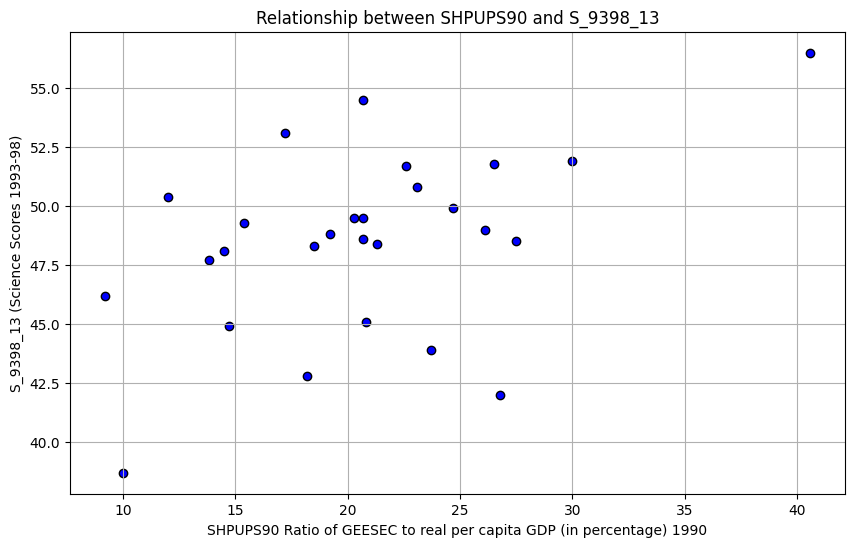

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(df_science_merged['SHPUPS90'], y, color='blue', edgecolor='k')
plt.title('Relationship between SHPUPS90 and S_9398_13')
plt.xlabel('SHPUPS90 Ratio of GEESEC to real per capita GDP (in percentage) 1990')
plt.ylabel('S_9398_13 (Science Scores 1993-98)')
plt.grid(True)
plt.show()

In [43]:

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=14)

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_science_knn['One Feature'] = rmse_knn
rmse_science_linear['One Feature'] = rmse_linear

rmse_knn, rmse_linear

(4.0009462741250825, 3.6399509993798667)

# Science conclusion:

The most effective model was a Linear Regression model using just a single feature: SHPUPS90 (Ratio of Government Expenditure on Secondary Education to real per capita GDP in 1990). It got an RMSE of 4.01, indicating strong predictive performance

- This may emphasize the importance of financial investment in education (at secondary level)
- Also shows that sometimes a simple model with just one feature (SHPUPS90) was sufficient to capture the relationship between government expenditure and science scores

# Predicting Reading Score (R_9091_13)

Since we are now trying to predict exams that happened in the year 1990-91, it makes more sense to start analyzing the features from the closest year that happened before, in this case 1985

In [44]:
df_reading_9091_13 = df_quality2[['SHCODE', 'COUNTRY', 'R_9091_13']].dropna(subset=['R_9091_13'])

In [45]:

df_quality_selected = df_quality1[['SHCODE', 'COUNTRY'] + features_1985]
df_reading_merged = pd.merge(df_reading_9091_13, df_quality_selected, on=['SHCODE', 'COUNTRY'], how='inner')


In [46]:
rmse_reading_knn = {}
rmse_reading_linear = {}

Different from the previous cases, using only the features from 1985, we actually have just a few rows (3) with Nan values. Since we have so few are simply going to drop them

In [47]:

df_reading_merged['SCHTIME'] = df_reading_merged['SCHTIME'].fillna(df_reading_merged['SCHTIME'].mean())
df_reading_merged.head()

,SHCODE,COUNTRY,R_9091_13,TEAPRI85,TEASEC85,GEEPRI85,GEESEC85,SHPUPS85,SALARP85,SHSALP85,SCHDAY,SCHTIME
0,4,Botswana,33.0,32.000000,21.600000,207.0,1436.0,63.799999,6469.0,287.0,190.0,912.000000
1,32,Nigeria,40.1,44.099998,36.200001,NaN,NaN,NaN,NaN,NaN,198.0,986.666667
2,47,Zimbabwe,37.2,39.500000,27.799999,232.0,457.0,38.799999,9026.0,766.0,195.0,1053.000000
3,50,Canada,52.2,16.700001,14.900000,4139.0,4413.0,28.100000,45864.0,292.0,195.0,975.000000
4,66,United States,53.5,19.600000,13.400000,3210.0,4029.0,24.299999,24728.0,149.0,179.0,1148.000000


In [48]:
df_reading_merged = df_reading_merged.dropna()
df_reading_merged

,SHCODE,COUNTRY,R_9091_13,TEAPRI85,TEASEC85,GEEPRI85,GEESEC85,SHPUPS85,SALARP85,SHSALP85,SCHDAY,SCHTIME
0,4,Botswana,33.0,32.000000,21.600000,207.0,1436.0,63.799999,6469.0,287.0,190.0,912.000000
2,47,Zimbabwe,37.2,39.500000,27.799999,232.0,457.0,38.799999,9026.0,766.0,195.0,1053.000000
3,50,Canada,52.2,16.700001,14.900000,4139.0,4413.0,28.100000,45864.0,292.0,195.0,975.000000
4,66,United States,53.5,19.600000,13.400000,3210.0,4029.0,24.299999,24728.0,149.0,179.0,1148.000000
5,78,Venezuela,41.7,32.700001,17.299999,288.0,1182.0,19.600000,7954.0,132.0,180.0,900.000000
6,84,Hong Kong,53.5,27.600000,24.000000,849.0,1217.0,11.400000,23124.0,217.0,208.0,986.666667
7,98,Philippines,43.0,30.900000,32.299999,73.0,32.0,2.100000,1640.0,108.0,185.0,925.000000
8,100,Singapore,53.4,26.799999,22.200001,738.0,1371.0,16.799999,22331.0,274.0,208.0,986.666667
9,104,Thailand,47.7,19.299999,21.200001,341.0,392.0,16.200001,5799.0,239.0,200.0,1200.000000
10,108,Belgium,48.1,16.500000,7.900000,2174.0,3615.0,31.900000,31028.0,274.0,182.0,986.666667


In [49]:
dic = dict()

for feature in features_1985:
    dic[feature] = df_reading_merged[feature].corr(df_reading_merged['R_9091_13'])

corrs = pd.Series(dic, name='Correlation')
corrs.sort_values()


,Correlation
TEAPRI85,-0.698264
SHPUPS85,-0.547573
TEASEC85,-0.518403
SHSALP85,-0.334299
SCHDAY,0.078638
SCHTIME,0.135264
GEESEC85,0.407706
GEEPRI85,0.488989
SALARP85,0.589444


As we can see, with reading that are some features that have pretty strong correlations

# Reading: Model using all features

In [50]:
scaler = StandardScaler()

X = scaler.fit_transform(df_reading_merged[features_1985])
y = df_reading_merged['R_9091_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='manhattan', n_neighbors=10)

In [51]:
# Defining models, KNN using best params
linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=10, metric='manhattan')

In [52]:
rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_reading_knn['All Features'] = rmse_knn
rmse_reading_linear['All Features'] = rmse_linear

rmse_knn, rmse_linear

(5.317682766017545, 7.953826818058364)

# Reading: Model using features with stronger correlation

In [53]:

features_highest_corr = ['TEAPRI85', 'SHPUPS85', 'TEASEC85'] # 3 negative correlations
features_highest_corr2 = ['TEAPRI85', 'SALARP85'] # 1 negative 1 positive

scaler = StandardScaler()
X = scaler.fit_transform(df_reading_merged[features_highest_corr])
y = df_reading_merged['R_9091_13']

findsBestParametersKNN(X, y)


KNeighborsRegressor(metric='manhattan')

In [54]:
scaler = StandardScaler()

X2 = scaler.fit_transform(df_reading_merged[features_highest_corr2])

findsBestParametersKNN(X2, y)

KNeighborsRegressor(metric='manhattan', n_neighbors=1)

In [55]:

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=8, metric='manhattan')
knn_model2 = KNeighborsRegressor(n_neighbors=2, metric='manhattan')

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_knn2 = calculatesRMSEusingCV(knn_model2, X2, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)
rmse_linear2 = calculatesRMSEusingCV(linear_model, X2, y)

rmse_reading_knn['Top 3 Features'] = rmse_knn2
rmse_reading_linear['Top 3 Features'] = rmse_linear2

rmse_knn, rmse_knn2, rmse_linear, rmse_linear2

(5.541208126392655, 4.20397133672436, 6.012490568878217, 5.104868456036103)

# Reading: Model using one feature

In [56]:

feature_with_highest_corr = ['TEAPRI85']

scaler = StandardScaler()
X = scaler.fit_transform(df_reading_merged[feature_with_highest_corr])
y = df_reading_merged['R_9091_13']

findsBestParametersKNN(X, y)

KNeighborsRegressor(metric='euclidean', n_neighbors=1)

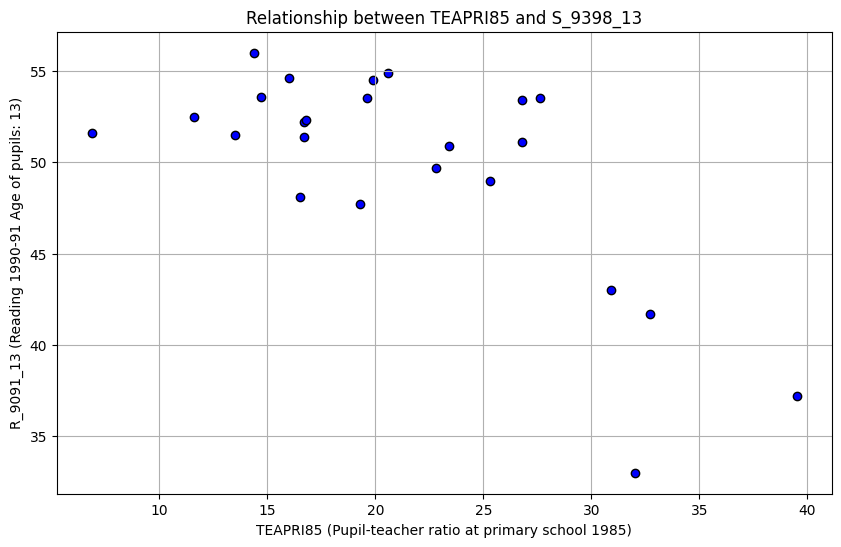

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(df_reading_merged['TEAPRI85'], y, color='blue', edgecolor='k')
plt.title('Relationship between TEAPRI85 and S_9398_13')
plt.xlabel('TEAPRI85 (Pupil-teacher ratio at primary school 1985)')
plt.ylabel('R_9091_13 (Reading 1990-91 Age of pupils: 13)')
plt.grid(True)
plt.show()

In [58]:

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=1)

rmse_knn = calculatesRMSEusingCV(knn_model, X, y)
rmse_linear = calculatesRMSEusingCV(linear_model, X, y)

rmse_reading_knn['One Feature'] = rmse_knn
rmse_reading_linear['One Feature'] = rmse_linear

rmse_knn, rmse_linear

(4.101292479207012, 5.505602903866341)

# Reading conclusion:

The most effective model was a Linear Regression model using just a single feature: TEAPRI85 (Pupil-teacher ratio at primary school 1985). It got an RMSE of 3.97, indicating strong predictive performance

- This may emphasize the importance of Pupil-teacher ratio and good teachers in primary school
- Also shows that sometimes a simple model with just one feature (TEAPRI85) was sufficient to capture the relationship between government expenditure and reading scores

# Table containing all RMSE values

In [59]:
data = {
    'Test': ['Math', 'Math', 'Science', 'Science', 'Reading', 'Reading'],
    'Model': ['KNN', 'Linear Regression', 'KNN', 'Linear Regression', 'KNN', 'Linear Regression'],
    'All Features': [rmse_math_knn['All Features'], rmse_math_linear['All Features'], rmse_science_knn['All Features'], rmse_science_linear['All Features'], rmse_reading_knn['All Features'], rmse_reading_linear['All Features']],
    'Top 3 Features': [rmse_math_knn['Top 3 Features'], rmse_math_linear['Top 3 Features'], rmse_science_knn['Top 3 Features'], rmse_science_linear['Top 3 Features'], rmse_reading_knn['Top 3 Features'], rmse_reading_linear['Top 3 Features']],
    'Features 1985 + 1990': [rmse_math_knn['Features 1985 + 1990'], rmse_math_linear['Features 1985 + 1990'], rmse_science_knn['Features 1985 + 1990'], rmse_science_linear['Features 1985 + 1990'], None, None],
    'Single Feature': [rmse_math_knn['One Feature'], rmse_math_linear['One Feature'], rmse_science_knn['One Feature'], rmse_science_linear['One Feature'], rmse_reading_knn['One Feature'], rmse_reading_linear['One Feature']],
}

df_rmse = pd.DataFrame(data)

df_rmse.set_index(['Test', 'Model'], inplace=True)
df_rmse

All Features  Top 3 Features  Features 1985 + 1990  \
Test    Model                                                                   
Math    KNN                    5.112862        4.681719              5.015430   
        Linear Regression      9.860945        4.581452             15.571569   
Science KNN                    3.843996        3.969648              3.943326   
        Linear Regression      6.399934        3.904830              9.555138   
Reading KNN                    5.317683        4.203971                   NaN   
        Linear Regression      7.953827        5.104868                   NaN   

                           Single Feature  
Test    Model                              
Math    KNN                      4.747509  
        Linear Regression        4.374146  
Science KNN                      4.000946  
        Linear Regression        3.639951  
Reading KNN                      4.101292  
        Linear Regression        5.505603

# Overall Conclusion

The analysis conducted for predicting math, science, and reading test scores based on various educational and economic indicators has provided some insights:

### Predictive power of educational inputs:
The results indicate that certain educational inputs, such as government expenditure on education, pupil-teacher ratios, and teacher salaries, play a significant role in predicting a country's performance in international test scores. But the that different features have more impact than other when it comes to specific types of tests, ex:

- The feature that influences reading the most is: TEAPRI85 (Pupil-teacher ratio at primary school 1985)

- The feature that influences science the most is: SHPUPS90 Ratio of GEESEC to real per capita GDP (in percentage) 1990

- Meanwhile the math test seems to be influenced by a combination of educational inputs over time, rather than just a single year's data.

### Model Performance:

Interestingly, the analysis showed that in some cases, simple models with just one or two features can outperform more complex models. This was particularly evident in the prediction of science and reading scores, where single features related to economic investment or pupil-teacher ratios were highly predictive. This reinforces the importance of identifying and focusing on the most impactful variables when building predictive models.

### Final Takeaway
Overall, the project demonstrates that a thoughtful combination of historical educational and economic indicators can provide accurate predictions of international test scores. The findings underscore the importance of targeted investments in education, particularly when it comes to pupil-teacher ratios and increasing financial support

The success of simpler models in some cases also highlights the value of focusing on the most significant features when making predictions. This analysis can serve as a valuable reference for policymakers and educators aiming to enhance educational outcomes on a global scale.